In [1]:
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import numpy as np
import plotting as plot

from sc_qubits import sc_qubits2 as qubit  # import the superconducting circuit module

import multiprocessing as mp
import time
from numpy import linalg as la
from functools import partial
import scipy.sparse as sp
#from scipy.sparse import linalg as la
%autosave 0

from qutip import *

%load_ext line_profiler

from quantum_optimal_control.helper_functions.grape_functions import *
from quantum_optimal_control.main_grape.grape import Grape

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Autosave disabled


# Initialize 0-pi qubit parameters

In [28]:
T = 0.015
kb = 1.3806e-23
h = 6.626e-34
hbar = h / (2*np.pi)
beta = 1./(kb*T)
giga = 1e9

op = 2*np.pi*40
EJ_const = 0.25#0.165
ECJ_const = (1 / (8*EJ_const))
ECS_const = 0.001#0.00035
EL_const = 0.001

gate_coupling_theta = 1.0
gate_coupling_phi = 1.0

zero_pi_dim = 30

phitheta_grid = qubit.Grid(
    np.asarray([ 
        [-6*np.pi, 6*np.pi, 200], # phi variable
        [-np.pi/2, 3*np.pi/2, 200]   # theta variable (2pi periodic!)
    ])
    )
# Hamiltonian discritized in 2D phi-theta space (\ket{phi,theta}) (position space representation of states) 
symmetric_zero_pi = qubit.SymZeroPi(
    EJ = EJ_const,
    EL = EL_const,
    ECJ = ECJ_const,
    ECS = ECS_const,
    flux = 0.0,
    grid = phitheta_grid
)

symmetric_zero_pi_offset = qubit.SymZeroPiNg(
    EJ = EJ_const,
    EL = EL_const,
    ECJ = ECJ_const,
    ECS = ECS_const,
    flux = 0,
    ng = 0.25,
    grid = phitheta_grid
)

# # Hamiltonian discritized in 3D phi-theta-chi space (\ket{phi,theta,chi}) (dont really use this)
# disordered_zero_pi = qubit.fullZeroPi(
#     EJ
#     EL
#     ECJ
#     ECS
#     EC
#     dEJ
#     dCJ
#     dC
#     dEL
#     flux
#     grid
#     truncated_dim
# )

# Full Hamiltonian of 0pi coupled to chi mode via disorder in L and C
disordered_zero_pi = qubit.FullZeroPi_ProductBasis(
    EJ = EJ_const,
    EL = EL_const,
    ECJ = ECJ_const,
    ECS = ECS_const,
    EC = 1/(1/ECS_const-1/ECJ_const),
    dEJ = 0,
    dCJ = 0, 
    dC = 0.08,
    dEL = 0.08,
    flux = 0,
    ng = 0,
    zeropi_cutoff = zero_pi_dim,
    chi_cutoff = 40,
    grid = phitheta_grid
)

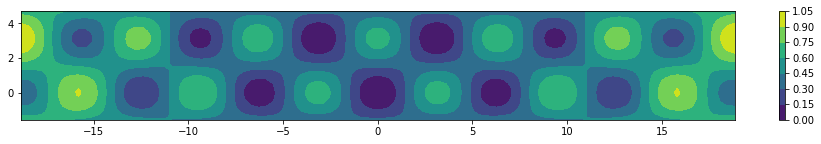

In [8]:
symmetric_zero_pi.plot_potential(aspect_ratio=0.12)
#symmetric_zero_pi_offset.plot_potential(contour_vals=np.linspace(0,1.1,25), aspect_ratio=0.12)


[====================] 100% Done.


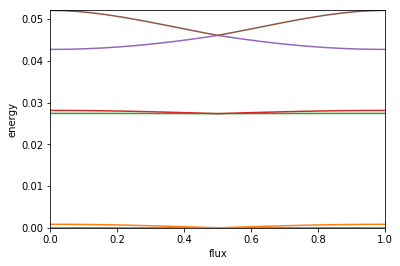

In [5]:
flux_list = np.linspace(0, 1, 25)
symmetric_zero_pi.plot_evals_vs_paramvals('flux', flux_list, subtract_ground=True)

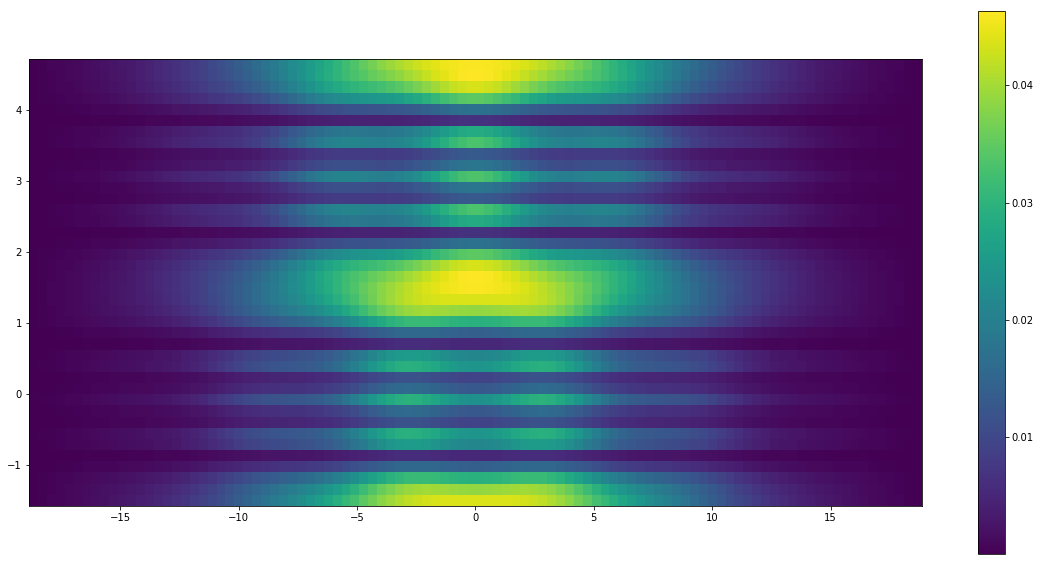

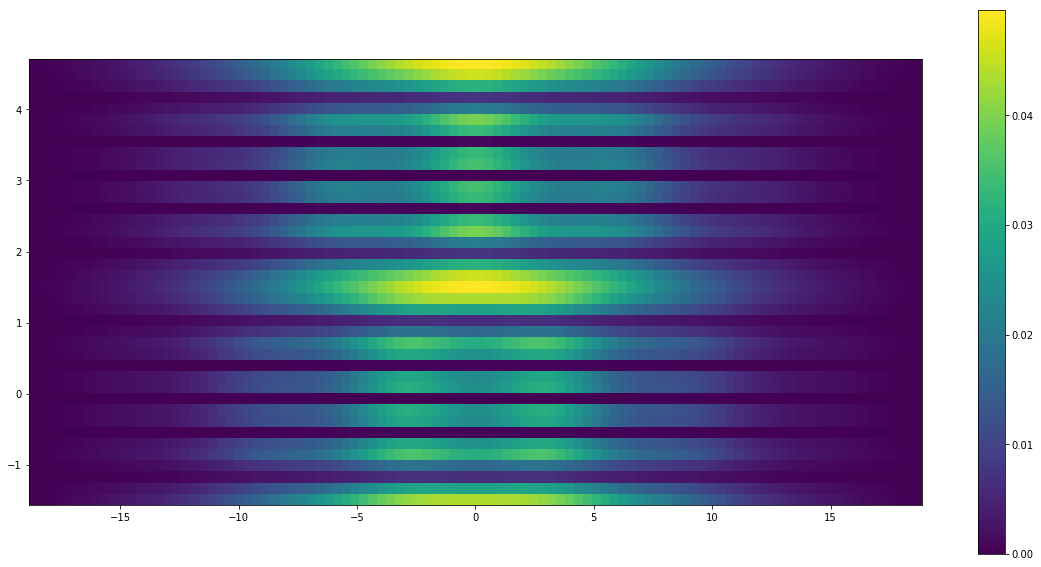

In [52]:
symmetric_zero_pi.flux = 0.0
esys = symmetric_zero_pi.eigensys(zero_pi_dim)
symmetric_zero_pi.plot_wavefunction(esys, which=8, mode='abs')
symmetric_zero_pi.plot_wavefunction(esys, which=10, mode='abs')

In [18]:
ev_count = 10
zeropi_evals, zeropi_states = symmetric_zero_pi._esys_calc(evals_count=ev_count)
g_theta_mat = disordered_zero_pi.g_theta_coupling_matrix(zeropi_states)
#plot.matrixelements(g_theta_mat, xlabel="l", ylabel="l'", zlabel="g_{ll'}")
#g_phi_mat = disordered_zero_pi.g_phi_coupling_matrix(zeropi_states)
#plot.matrixelements(g_phi_mat, xlabel="l", ylabel="l'", zlabel="g_{ll'}")

# Setup control Hamiltonian

[0.42572017 0.42659212 0.4536712  0.45440836 0.46792292 0.47748502
 0.47961906 0.48025439 0.49809003 0.49973754 0.50285405 0.50381849
 0.50663805 0.52109113 0.52580874 0.5263963  0.53150432 0.53335131
 0.53399166 0.53476835 0.53988419 0.54798701 0.55047489 0.55251182
 0.55909604 0.56205048 0.56335168 0.5715859  0.57269666 0.57303606]


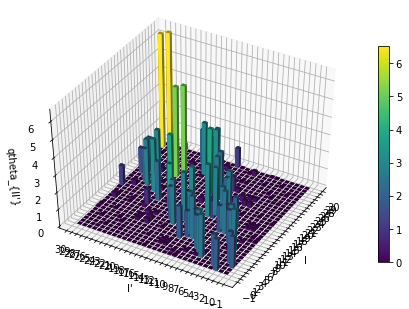

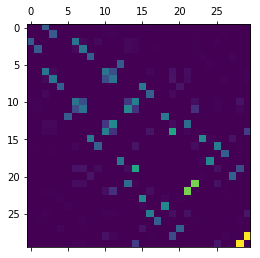

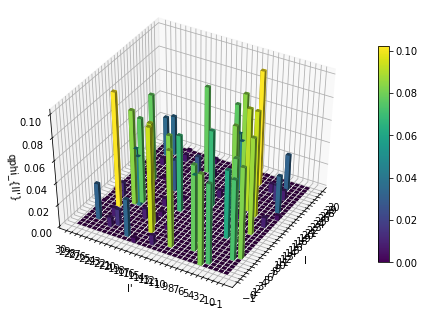

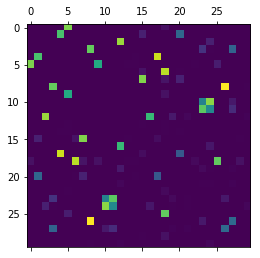

In [29]:
# evalulate charge matrix elements
symmetric_zero_pi.flux = 0.0
ev_count = zero_pi_dim
zeropi_evals, zeropi_states = symmetric_zero_pi._esys_calc(evals_count=ev_count)
print(zeropi_evals)
q_theta_mat = qubit.matrixelem_table(symmetric_zero_pi.i_d_dtheta_operator(), zeropi_states)
q_phi_mat = qubit.matrixelem_table(symmetric_zero_pi.i_d_dphi_operator(), zeropi_states)

plot.matrixelements(q_theta_mat, xlabel="l", ylabel="l'", zlabel="qtheta_{ll'}")
plot.matrixelements(q_phi_mat, xlabel="l", ylabel="l'", zlabel="qphi_{ll'}")

## Optimal Control Interface:

data saved at: ../00002_symmetric_zero_pi.h5


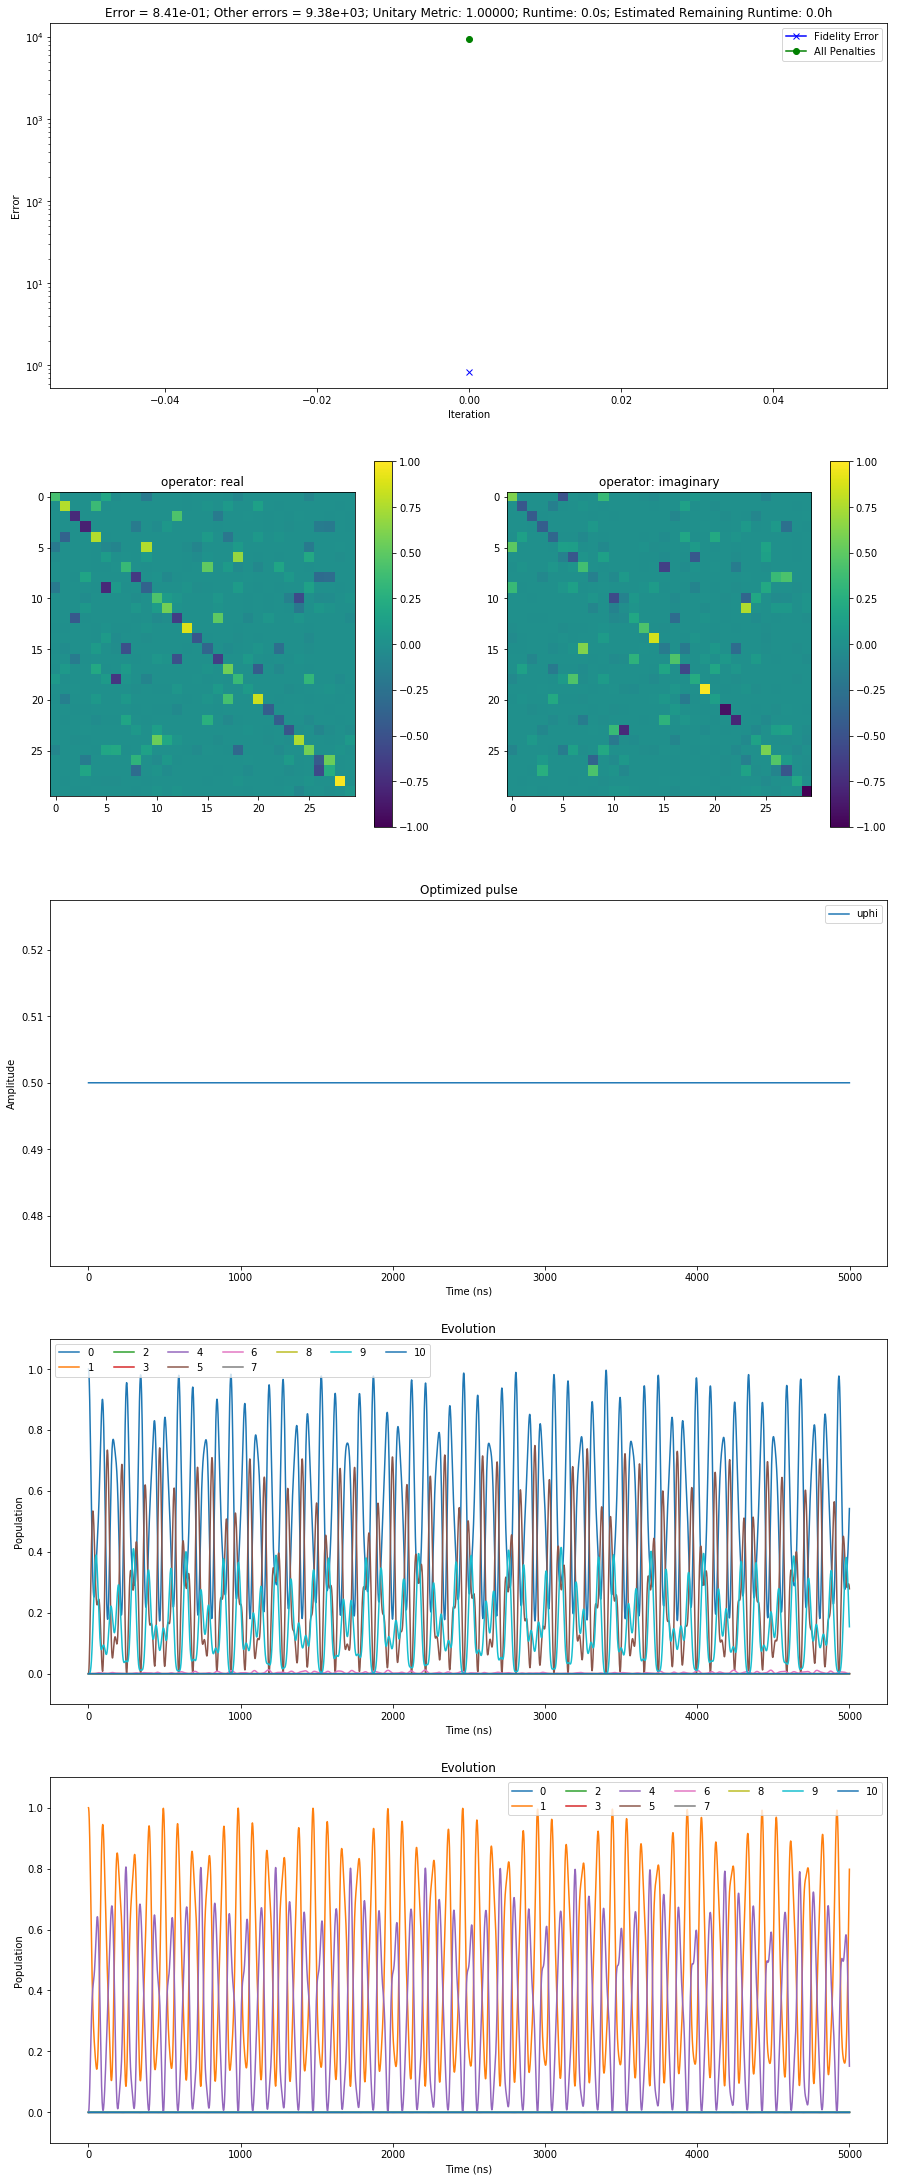

In [34]:
total_time = 5000
steps = 5000

data_path = '../'

zeropi_hamiltonian = np.zeros(shape=(zero_pi_dim, zero_pi_dim))
for i in range(zero_pi_dim):
    zeropi_hamiltonian[i][i] = zeropi_evals[i]

# these are the control operators, q_theta and q_phi
H_ops = [q_phi_mat]#, 
H_names = [b'phi']#,

states_concerned = [0,1]

mu = total_time*0.5
sigma = 0.15*total_time
alpha = 1.0 # ramp rate
chi = 0.025# strength
shift = 0.02
time = np.linspace(0,total_time,steps)
gaussian = chi*np.exp(-0.5*((time - mu)/(sigma))**2)
gaussian_phi = 0.8*np.exp(-0.5*((time - mu)/(sigma))**2)
ramp_phi = 10*chi*(1/(1+np.exp(-alpha*(time-shift*total_time))))*np.heaviside(-time + total_time*0.5,0.5) + 10*chi*(1/(1+np.exp(alpha*(time+shift*total_time-total_time))))*np.heaviside(time - total_time*0.5,0.5)
ramp = chi*(1/(1+np.exp(-alpha*(time-shift*total_time))))*np.heaviside(-time + total_time*0.5,0.5) + chi*(1/(1+np.exp(alpha*(time+shift*total_time-total_time))))*np.heaviside(time - total_time*0.5,0.5)
square = np.full((steps,1),0.5)
nothing = np.zeros(shape=(1,steps))
guess_pulse = [square]#,ramp_phi] # maybe use paper V_g and t_g

Ut_c = np.zeros(shape=(zero_pi_dim, zero_pi_dim))#la.expm(1j*total_time*zeropi_hamiltonian)
Ct_c = Ut_c.copy()
Ct_c[1,0] = 2**-0.5
Ct_c[0,1] = 2**-0.5
Ct_c[0,0] = -2**-0.5
Ct_c[1,1] = 2**-0.5
U = Ct_c

#Defining convergence parameters
max_iterations = 5000
decay = 1000
convergence = {'rate':0.001,'update_step':100,'max_iterations':max_iterations,\
               'conv_target':1e-4,'learning_rate_decay':decay}
max_a = [1.0]#0.0,100.0]

#Defining states to include in the drawing of occupation
states_draw_list = [0,1,2,3,4,5,6,7,8,9,10]
states_draw_names = ['0','1','2','3','4','5','6','7','8','9','10']
#forbidden_list = [12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]

reg_coeffs = {'amplitude':75000.0,'dwdt':200000.0} #{'amplitude':0.0}
u0 = None

uks, U_final = Grape(zeropi_hamiltonian,H_ops,H_names,U,total_time,steps,states_concerned,convergence,u0,reg_coeffs,maxA=max_a,draw =[states_draw_list,states_draw_names],use_gpu=False,initial_guess = guess_pulse,method = b'EVOLVE',file_name='symmetric_zero_pi',data_path = data_path)
